# Retrieve and view a stamp of a single galaxy

<br>Owner: **Daniel Perrefort** ([@djperrefort](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@djperrefort))
<br>Updated for DC2 by:   Douglas Tucker ([@douglasleetucker](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@douglasleetucker)) following in part work for DESC by Yao-Yuan Mao (@yymao) and Johann Cohen-Tanugi (@johannct). Edited by Matt Wiesner.
<br>Last Verified to Run: **2021-03-09**
<br>Verified Stack Release: **w_2021_18**


In [1]:
import numpy as np
print( 'numpy version: ', np.__version__ )

import matplotlib
print( 'matplotlib version: ', matplotlib.__version__ )

from lsst.daf.persistence import Butler # gen2 butler
import lsst.daf.butler as dafButler     # gen3 butler
# What version of the LSST Science Pipelnes are we using?
! echo $IMAGE_DESCRIPTION
! eups list -s | grep lsst_distrib

import pandas as pd
pd.set_option('display.max_rows', 1000)

import lsst
import lsst.sphgeom

# allow for matplotlib to create inline plots in our notebook
%matplotlib inline
import matplotlib.pyplot as plt      # imports matplotlib.pyplot as plt
import warnings                      # imports the warnings library

from astropy.wcs import WCS          # imports astropy's World Coordinate System function WCS

from IPython.display import Markdown as md

# from rubin_jupyter_utils.lab.notebook import get_catalog, retrieve_query    
from rubin_jupyter_utils.lab.notebook import get_tap_service, retrieve_query    

import lsst.afw.display as afwDisplay
import lsst.geom
from lsst.geom import SpherePoint, Angle
afwDisplay.setDefaultBackend('matplotlib') 

repo = 's3://butler-us-central1-dp01'  
#collection='2.2i/runs/DP0.1'
#collection='1.2i/runs/DP0.1'

# Get an instance of the TAP service
service = lsst.rsp.get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

dataset='DC2'
#genvers='gen2'
genvers='gen3'

# Temporary "fix" so one does not need to restart kernel 
#  when switching from DC2 to HSC...
# See also:  https://lsstc.slack.com/archives/C3UCAEW3D/p1584386779038000
#import lsst.afw.image as afwImage
#print(afwImage.Filter.getNames())
#afwImage.Filter.reset()
import lsst.obs.base as obsBase
obsBase.FilterDefinitionCollection.reset()
#print(afwImage.Filter.getNames())

# Access DC2 gen3 repository
#repo='/repo/dc2'
#collection='2.2i/runs/DP0.1'
#repo='s3://butler-us-central1-dp01'
collection=['2.2i/runs/DP0.1/calexp/v1', 
                    '2.2i/runs/DP0.1/coadd/wfd/dr6/v1', 
                    '2.2i/runs/DP0.1/coadd/wfd/dr6/v1/u', 
                    '2.2i/runs/DP0.1/coadd/wfd/dr6/v1/grizy',
                    'skymaps']

# Open the butler for this gen3 repo...
butler = dafButler.Butler(repo,collections=collection)

import matplotlib.pyplot as plt


numpy version:  1.23.5
matplotlib version:  3.6.3


ModuleNotFoundError: No module named 'lsst.daf.persistence'

# Input coordinates
This is where we define the coordinates of interest

In [2]:
#This is the subscript for the array
ii = 20

filter_id = 'r'
data = pd.read_csv('input.txt', delim_whitespace=True)

ra1 = data['ra_2']
dec1 = data['dec_2']
#mag1 =  data['mag_r_2']

#print(ra1)

#print(ra.iloc[1])

ra = ra1.iloc[ii]
dec = dec1.iloc[ii]
#mag_r = mag1.iloc[ii]

NameError: name 'pd' is not defined

# Find tract and patch associate with input

In [3]:
#my_spherePoint = lsst.geom.SpherePoint(55.745834*lsst.geom.degrees, -32.269167*lsst.geom.degrees)
my_spherePoint = lsst.geom.SpherePoint(ra*lsst.geom.degrees, dec*lsst.geom.degrees)
print(my_spherePoint)

#dataId = {'visit': 192350, 'detector': 175, 'band': 'i'}

skymap = butler.get('skyMap')
my_tract = skymap.findTract(my_spherePoint)
my_patch = my_tract.findPatch(my_spherePoint)
my_patch_id = my_tract.getSequentialPatchIndex(my_patch)
tract1 = str(my_tract)
patch1_ok = str(my_patch_id)
tract1_ok = tract1[13:17]
tract = int(tract1_ok)
patch = int(patch1_ok)

#dataId = """{'band': """+"""'"""+filter_id+"""','tract': """+tract1_ok+""", 'patch':"""+tract2+"""}"""

dataId = {'band': filter_id, 'tract': int(tract1_ok), 'patch':int(patch1_ok)}

print('my_tract = ', my_tract)
print('my_patch = ', my_patch)
print('my_patch_id = ',my_patch_id)
print(dataId)

NameError: name 'lsst' is not defined

## Creating Postage Stamps

When dealing with image data, we can use `Butler` to generate postage stamps at a given set of coordinates. For this example, we consider the `deepCoadd` data set, which has one extra key value than the previous example.

In [764]:
coadd_type = 'deepCoadd'

if genvers == 'gen2':
    butler.getKeys(coadd_type)
elif genvers == 'gen3':
    print(butler.registry.getDatasetType(coadd_type).dimensions.required.names)
print(dataId)

dict_keys(['band', 'skymap', 'tract', 'patch'])
{'band': 'r', 'tract': 3636, 'patch': 45}


Next, we retrieve the image using the `Butler`.

In [765]:
print(filter_id)
# Retrieve the image using butler
if genvers == 'gen2':
    coadd_id = {'tract': tract, 'patch': patch, 'filter': filter_id}
    image = butler.get(coadd_type, dataId=coadd_id)
elif genvers == 'gen3':
    coadd_id = {'tract': tract, 'patch': patch, 'band': filter_id}
    image = butler.get(coadd_type, dataId=coadd_id)

print(tract)
print(patch)
print(filter_id)
print(dataId)

r
3636
45
r
{'band': 'r', 'tract': 3636, 'patch': 45}


Since the postage stamp was generated using `Butler`, it is represented as an `afwImage` object. This is a data type from the DM stack that is used to represent images. Since it is a DM object, we choose to plot it using the DM `afwDisplay` module.

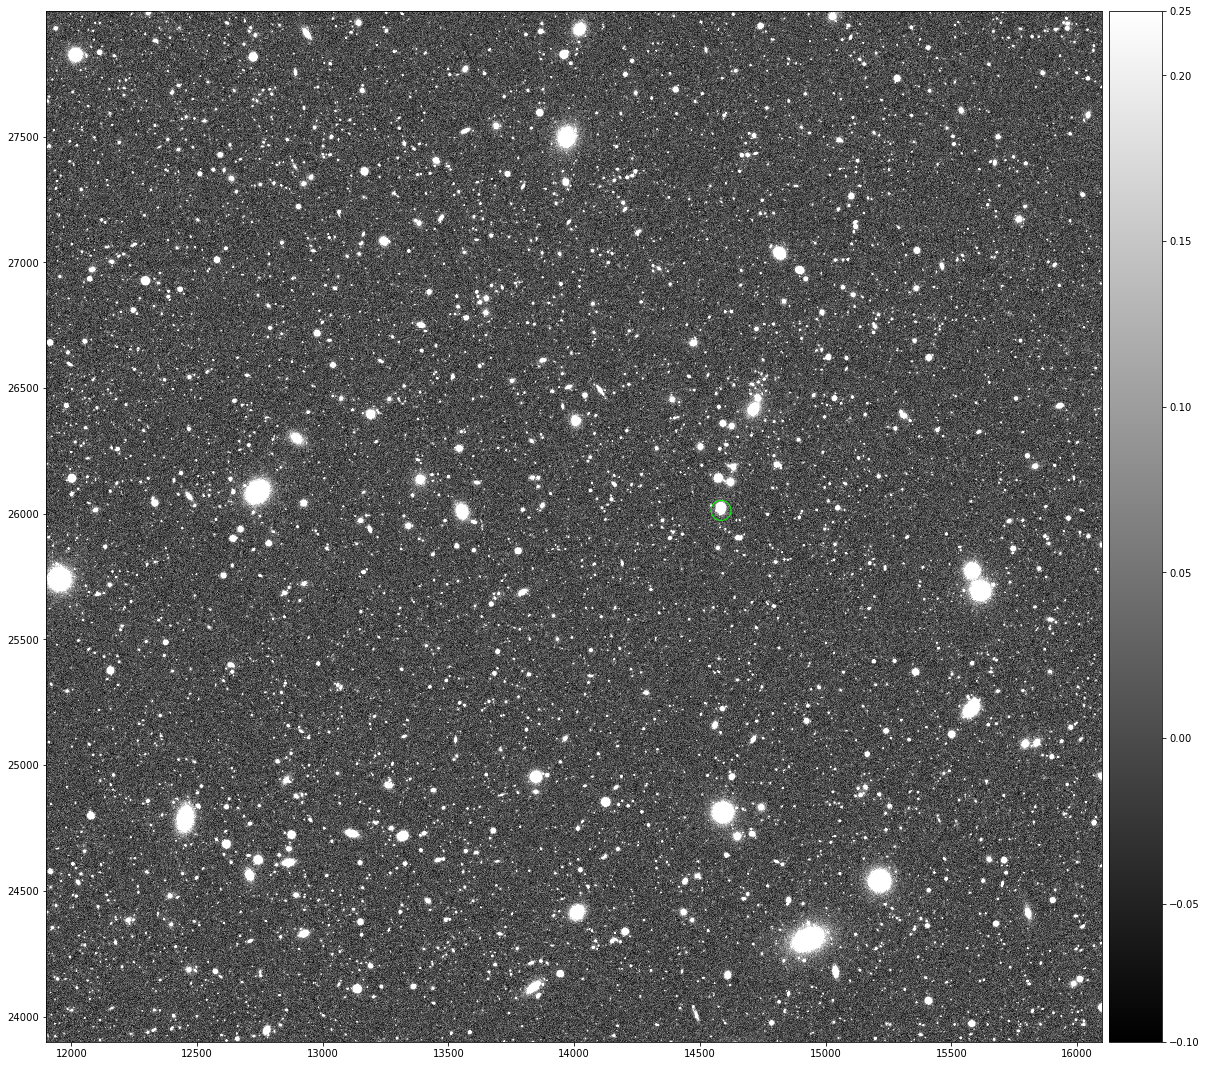

In [769]:
# Let's take a look at the full image first
radec = SpherePoint(ra, dec, lsst.geom.degrees)
xy = image.getWcs().skyToPixel(radec)

fig = plt.figure(figsize=(20,20))
display = afwDisplay.Display(frame=1, backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(image.getMaskedImage().getImage())
display.dot('o', xy.getX(), xy.getY(), ctype='green', size =40)


Next we plot our cutout from the full image.

In [1]:
fig, ax = plt.subplots(5, 4, figsize=(14, 7))
# Define the center and size of our cutout
radec = SpherePoint(ra, dec, lsst.geom.degrees)
cutout_size = 15
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

ra2 = ra-0.00012
dec2 = dec-0.00000
radec2 = SpherePoint(ra2, dec2, lsst.geom.degrees)
xy2 = image.getWcs().skyToPixel(radec2)
print(radec2)

# Cutout and optionally save the postage stamp to file
postage_stamp = image.getCutout(radec, cutout_extent)
# postage_stamp.writeFits(<output_filename>)

# Convert RA,DEC on the sky to X,Y in the image
xy = postage_stamp.getWcs().skyToPixel(radec)

# Display image
display = afwDisplay.Display(frame=1, backend='matplotlib')
display.mtv(postage_stamp.getImage())
display.scale("linear", "zscale")
display.dot('o', xy.getX(), xy.getY(), ctype='red', size=2)
display.dot('o', xy2.getX(), xy2.getY(), ctype='green', size=2)
display.show_colorbar()

plt.xlabel('x')
plt.ylabel('y')
plt.title('ra='+str(ra)+','+'dec='+str(dec)+','+'mag_r='+str(mag_r))
plt.show()


NameError: name 'plt' is not defined

The commands below are taken from the 03b_Image_Display_with_Firefly notebook from the tutorials. It displays the full image in Firefly.

In [294]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.Display(frame=1)

afw_display.mtv(postage_stamp.getImage())
#display.dot('o', np.degrees(ra), np.degrees(dec), ctype='red', size =60)


Note that the cutout image is aware of the masks and pixel values of the original image. This is why the axis labels in the above cutout are so large. We also note that the orientation of the postage stamp is in the x, y orientation of the original coadded image.


## Creating an RGB picture of a coadd patch¶ 

**NOTE:  This section will not work for the HSC data set, since the HSC data set only includes 2 filter bands ('HSC-I' and 'HSC-R').  This section, however, does work for the DC2 data set.  If you are not working with the DC data set, you may wish to skip down to the "Selecting an Area on the Sky with a Sky Map" section below.**

A nice and simple interface is also available to create pretty pictures of patch areas (stolen from D. Boutigny). We are using the same patch as above, and define our three colors as bands r,i and g. Then we ask the deepCoadd type from the butler, which corresponds to coadded images. We finally make use of the `afw.display` interface to build the RGB image.

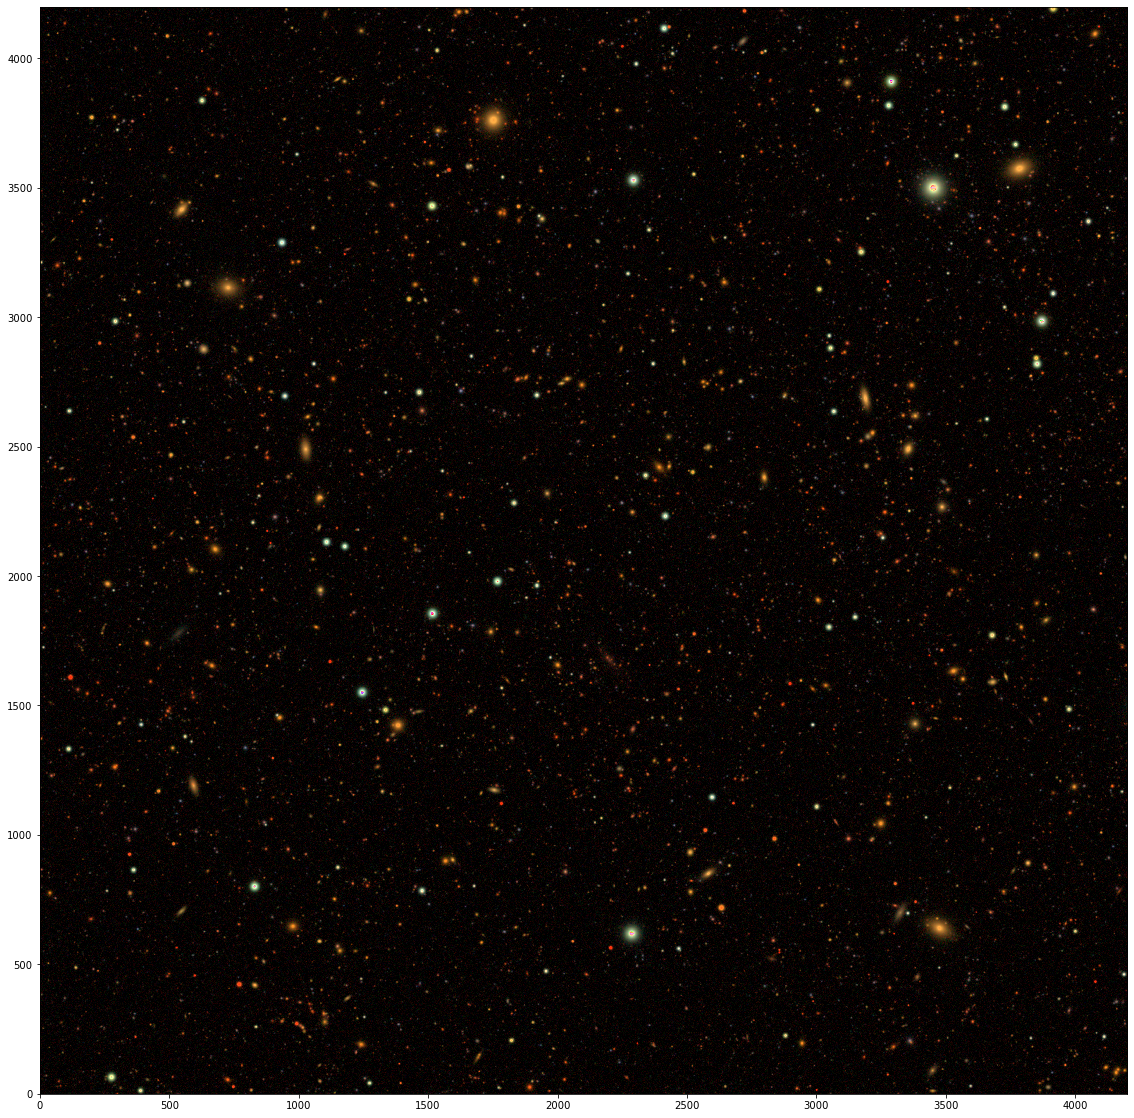

In [9]:
if dataset == 'DC2':

    import lsst.afw.display.rgb as rgb

    dataId = {'tract':tract, 'patch':patch}

    bandpass_color_map = {'green':'r', 'red':'i', 'blue':'g'} 

    exposures = {}
    for bandpass in bandpass_color_map.values():
        if genvers == 'gen2':
            dataId['filter'] = bandpass
        elif genvers == 'gen3':
            dataId['band'] = bandpass
        exposures[bandpass] = butler.get(coadd_type, dataId=dataId)

    fig = plt.figure(figsize=(20,20))
    rgb_im = rgb.makeRGB(*(exposures[bandpass_color_map[color]].getMaskedImage().getImage()
                           for color in ('red', 'green', 'blue')), Q=8, dataRange=1.0, 
                           xSize=None, ySize=None)

    rgb.displayRGB(rgb_im)
    
else:
    
    print('Sorry, it looks as though this section only works for the DC2 data set.')


In the RGB map the cluster appears very red!

Now we can also create RGB cutout images!

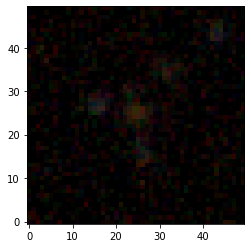

ra= 60.2152497
dec= -36.540807
mag_r= 25.407266
{'tract': 3830, 'patch': 24, 'band': 'g'}


In [10]:
rgb_im = rgb.makeRGB(*(exposures[bandpass_color_map[color]].getCutout(radec, cutout_extent).getMaskedImage().getImage()
                           for color in ('red', 'green', 'blue')), Q=8, dataRange=1.0, 
                           xSize=None, ySize=None)

rgb.displayRGB(rgb_im)

print("ra=", ra)
print("dec=", dec)
print("mag_r=",mag_r)
print(dataId)